## Index
---

- <a href='#1'><ins>1. Loading of Libraries and Data<ins></a>
- <a href='#2'><ins>2. Preprocessing data to enter it to the GAN<ins></a>
- <a href='#3'><ins>3. GAN architecture<ins> </a>
- <a href='#4'><ins>4. Re-train models with the augmented data<ins></a>
- <a href='#5'><ins>5. Results<ins></a>

### <a id='1'>1. Loading of Libraries and Data</a>
---

In [1]:
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import pandas as pd
import pickle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras import backend as K
from itertools import chain

import warnings
warnings.filterwarnings('ignore')

from __future__ import print_function, division

In [2]:
path_origin, path_processed = "../02_data/original_data/", "../02_data/processed_data/"
models_path, models_path_normal = "../03_models/gans_models/", "../03_models/models/"
palette = ['#264653','#2A9D8F','#85CAC2','#DFF6F4' ,'#E9C46A','#F4A261','#E76F51','#C53D1B', '#7E2711']
cells = [f'\Cell{x}\*' for x in range(1, 9)]
font = {'size': 16, 'color': 'black', 'weight': 'bold'}

In [3]:
df_desc_final_pickle_load = pd.read_pickle(path_processed + 'df_desc_final.pkl')
df_desc_final_pickle = df_desc_final_pickle_load[df_desc_final_pickle_load.RUL >= 0 ]
df_desc_final_pickle["RUL"] = df_desc_final_pickle["RUL"].astype(float)
print(df_desc_final_pickle.shape)

(390, 41)


In [4]:
from functions import ResultsFunctions as rf
from functions import LstmGansFunctions as lfg

### <a id='2'>Preprocessing data to enter it to the GAN</a>
---

In [5]:
X_train, num_steps, quantiles_final = [], 10, []
for i in range(1, 9):
    batery_df = df_desc_final_pickle[df_desc_final_pickle.index.get_level_values(0) == i]
    batery_df.index = pd.MultiIndex.from_tuples([(1, x) for x in range(1, batery_df.shape[0] + 1)])
    quantiles = []
    for j in range(1, len(batery_df) - num_steps):

        X_train.append(np.array(batery_df.loc[(1, slice(j,num_steps+j)), :].values))
        
X_train = np.array(X_train)
X_train.shape
X_train = np.stack(X_train, axis=0)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)

### <a id='3'>GAN architecture</a>
---

In [6]:
lstmgan = lfg.LSTMGAN(X_train)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 11, 256)          174080    
 l)                                                              
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 11, 256)           0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 256)              394240    
 nal)                                                            
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 256)               0         
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 repeat_vector (RepeatVector  (None, 1, 256)           0

We train the model and looking the best one we select it. Then we change the name manually to `GAN_LSTM`.    
These kind of models depends a lot on the random initialization, so we have to train several models and select the best one. So as to select the best one, there is no a unified metric, so we have to look at the loss and the validation loss when training with that synthetic data.

In [ ]:
lstmgan.train(epochs=3000, batch_size=128, save_interval=20)

### <a id='4'>Re-train model with augmented data</a>
---

We generate the new data points

In [6]:
batch_size = 128
random = np.random.normal(0, 1, (batch_size, X_train.shape[1], 41))
from keras.models import load_model
gan_model = load_model(models_path + "GAN_LSTM.h5")
X_train_augmented = gan_model.predict(random)
X_train_augmented = scaler.inverse_transform(X_train_augmented.reshape(-1, X_train_augmented.shape[-1])).reshape(X_train_augmented.shape)

4/4 [==============================] - 5s 29ms/step


Functio to get x and y

In [7]:
x, y = rf.x_and_y(df_desc_final_pickle, num_steps = 10, index = False)
X_train,X_test,y_train_mod,y_test_mod = train_test_split(x, y,test_size=0.2, random_state=42, stratify=y[:,[1,2]])
y_train, y_test = y_train_mod[:,0].reshape(-1,1), y_test_mod[:,0].reshape(-1,1)
X_train, y_train, X_test, y_test = np.stack(X_train, axis = 0), np.stack(y_train, axis = 0), np.stack(X_test, axis = 0), np.stack(y_test, axis = 0)

(302, 11, 40) (302, 3)


Concatenate new values to the original dataset

In [8]:
new_X_train, new_y_train = np.concatenate((X_train, X_train_augmented[:,:,:-1]), axis = 0), np.concatenate((y_train, X_train_augmented[:,:,-1][:,-1].reshape(-1,1)), axis = 0)
scaler = StandardScaler()
new_X_train = scaler.fit_transform(new_X_train.reshape(-1, new_X_train.shape[-1])).reshape(new_X_train.shape)
X_test = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

new_X_train.shape, new_y_train.shape

((369, 11, 40), (369, 1))

We load the best models and compile them again to train them with the augmented data.

**Model**

In [9]:
early_stopping = keras.callbacks.EarlyStopping(patience=3000, restore_best_weights=True)
reduce_lr = keras.callbacks.ReduceLROnPlateau(patience=150, factor=0.5, min_lr=0.00001)

lstm_model = keras.models.load_model(models_path_normal + f'Bidirectional_LSTM_adapted.h5', custom_objects={'customLoss': rf.customLoss})
lstm_hyperas_model = keras.models.load_model(models_path_normal + f'tryals_bidirectional_lstm_24.h5', custom_objects={'customLoss': rf.customLoss})

optimizer = keras.optimizers.Adam(learning_rate=0.0001)
lstm_model.compile(loss=rf.customLoss, optimizer=optimizer, metrics=['mae'])

Training the lstm

In [9]:
np.random.seed(26), tf.random.set_seed(26)
checkpoint_first_model_Bi_LSTM = keras.callbacks.ModelCheckpoint(models_path_normal + 'Bidirectional_LSTM_adapted_GAN.h5', verbose = 1, save_best_only=True, monitor='loss')
historyBiLSTM = lstm_model.fit(new_X_train, new_y_train, epochs=8000, batch_size=16, validation_split=0.2, verbose=0, shuffle=False, callbacks=[checkpoint_first_model_Bi_LSTM, early_stopping, reduce_lr])


Epoch 1: loss improved from inf to 216015.53125, saving model to ../data/processed_data/models\first_model_Bidirectional_LSTM_good_adapted_GAN_2.h5

Epoch 2: loss did not improve from 216015.53125

Epoch 3: loss improved from 216015.53125 to 91552.28125, saving model to ../data/processed_data/models\first_model_Bidirectional_LSTM_good_adapted_GAN_2.h5

Epoch 4: loss improved from 91552.28125 to 26454.10547, saving model to ../data/processed_data/models\first_model_Bidirectional_LSTM_good_adapted_GAN_2.h5

Epoch 5: loss improved from 26454.10547 to 20415.07812, saving model to ../data/processed_data/models\first_model_Bidirectional_LSTM_good_adapted_GAN_2.h5

Epoch 6: loss improved from 20415.07812 to 19405.96094, saving model to ../data/processed_data/models\first_model_Bidirectional_LSTM_good_adapted_GAN_2.h5

Epoch 7: loss improved from 19405.96094 to 16745.92773, saving model to ../data/processed_data/models\first_model_Bidirectional_LSTM_good_adapted_GAN_2.h5

Epoch 8: loss improv

### <a id='5'>5. Results</a>
---

In [9]:
model_gan = load_model(models_path_normal + "Bidirectional_LSTM_adapted_GAN.h5", custom_objects={'customLoss': rf.customLoss})
ypred = model_gan.predict(X_test)
print('Test -->', r2_score(y_test, ypred), mean_absolute_error(y_test, ypred), np.sqrt(mean_squared_error(y_test, ypred)), rf.customLoss_numpy(ypred, y_test))
green_list_1_test, yellow_list_1_test, red_list_1_test = rf.green_yellow_red(ypred, y_test, y_test_mod)
print(green_list_1_test, yellow_list_1_test, red_list_1_test)

ypred_train = model_gan.predict(new_X_train)
print('Train -->', r2_score(new_y_train, ypred_train), mean_absolute_error(new_y_train, ypred_train), np.sqrt(mean_squared_error(new_y_train, ypred_train)), rf.customLoss_numpy(ypred_train, new_y_train))
green_list_1_train, yellow_list_1_train, red_list_1_train = rf.green_yellow_red(ypred_train[:241], y_train, y_train_mod)
print(green_list_1_train, yellow_list_1_train, red_list_1_train)

2/2 [==============================] - 1s 68ms/step
Test --> 0.9947350921929261 64.22340568167265 99.40530944830282 4254595.930705044
80.32786885245902 16.39344262295082 3.278688524590164
12/12 [==============================] - 1s 63ms/step
Train --> 0.9979576524543002 38.793722592072115 49.22888927748032 413370.7946454527
100.0 0.0 0.0


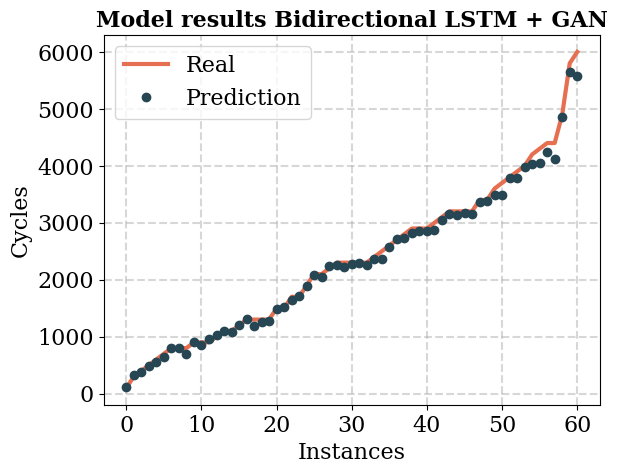

In [10]:
rf.line_plot_result(ypred, y_test, ' Bidirectional LSTM + GAN')

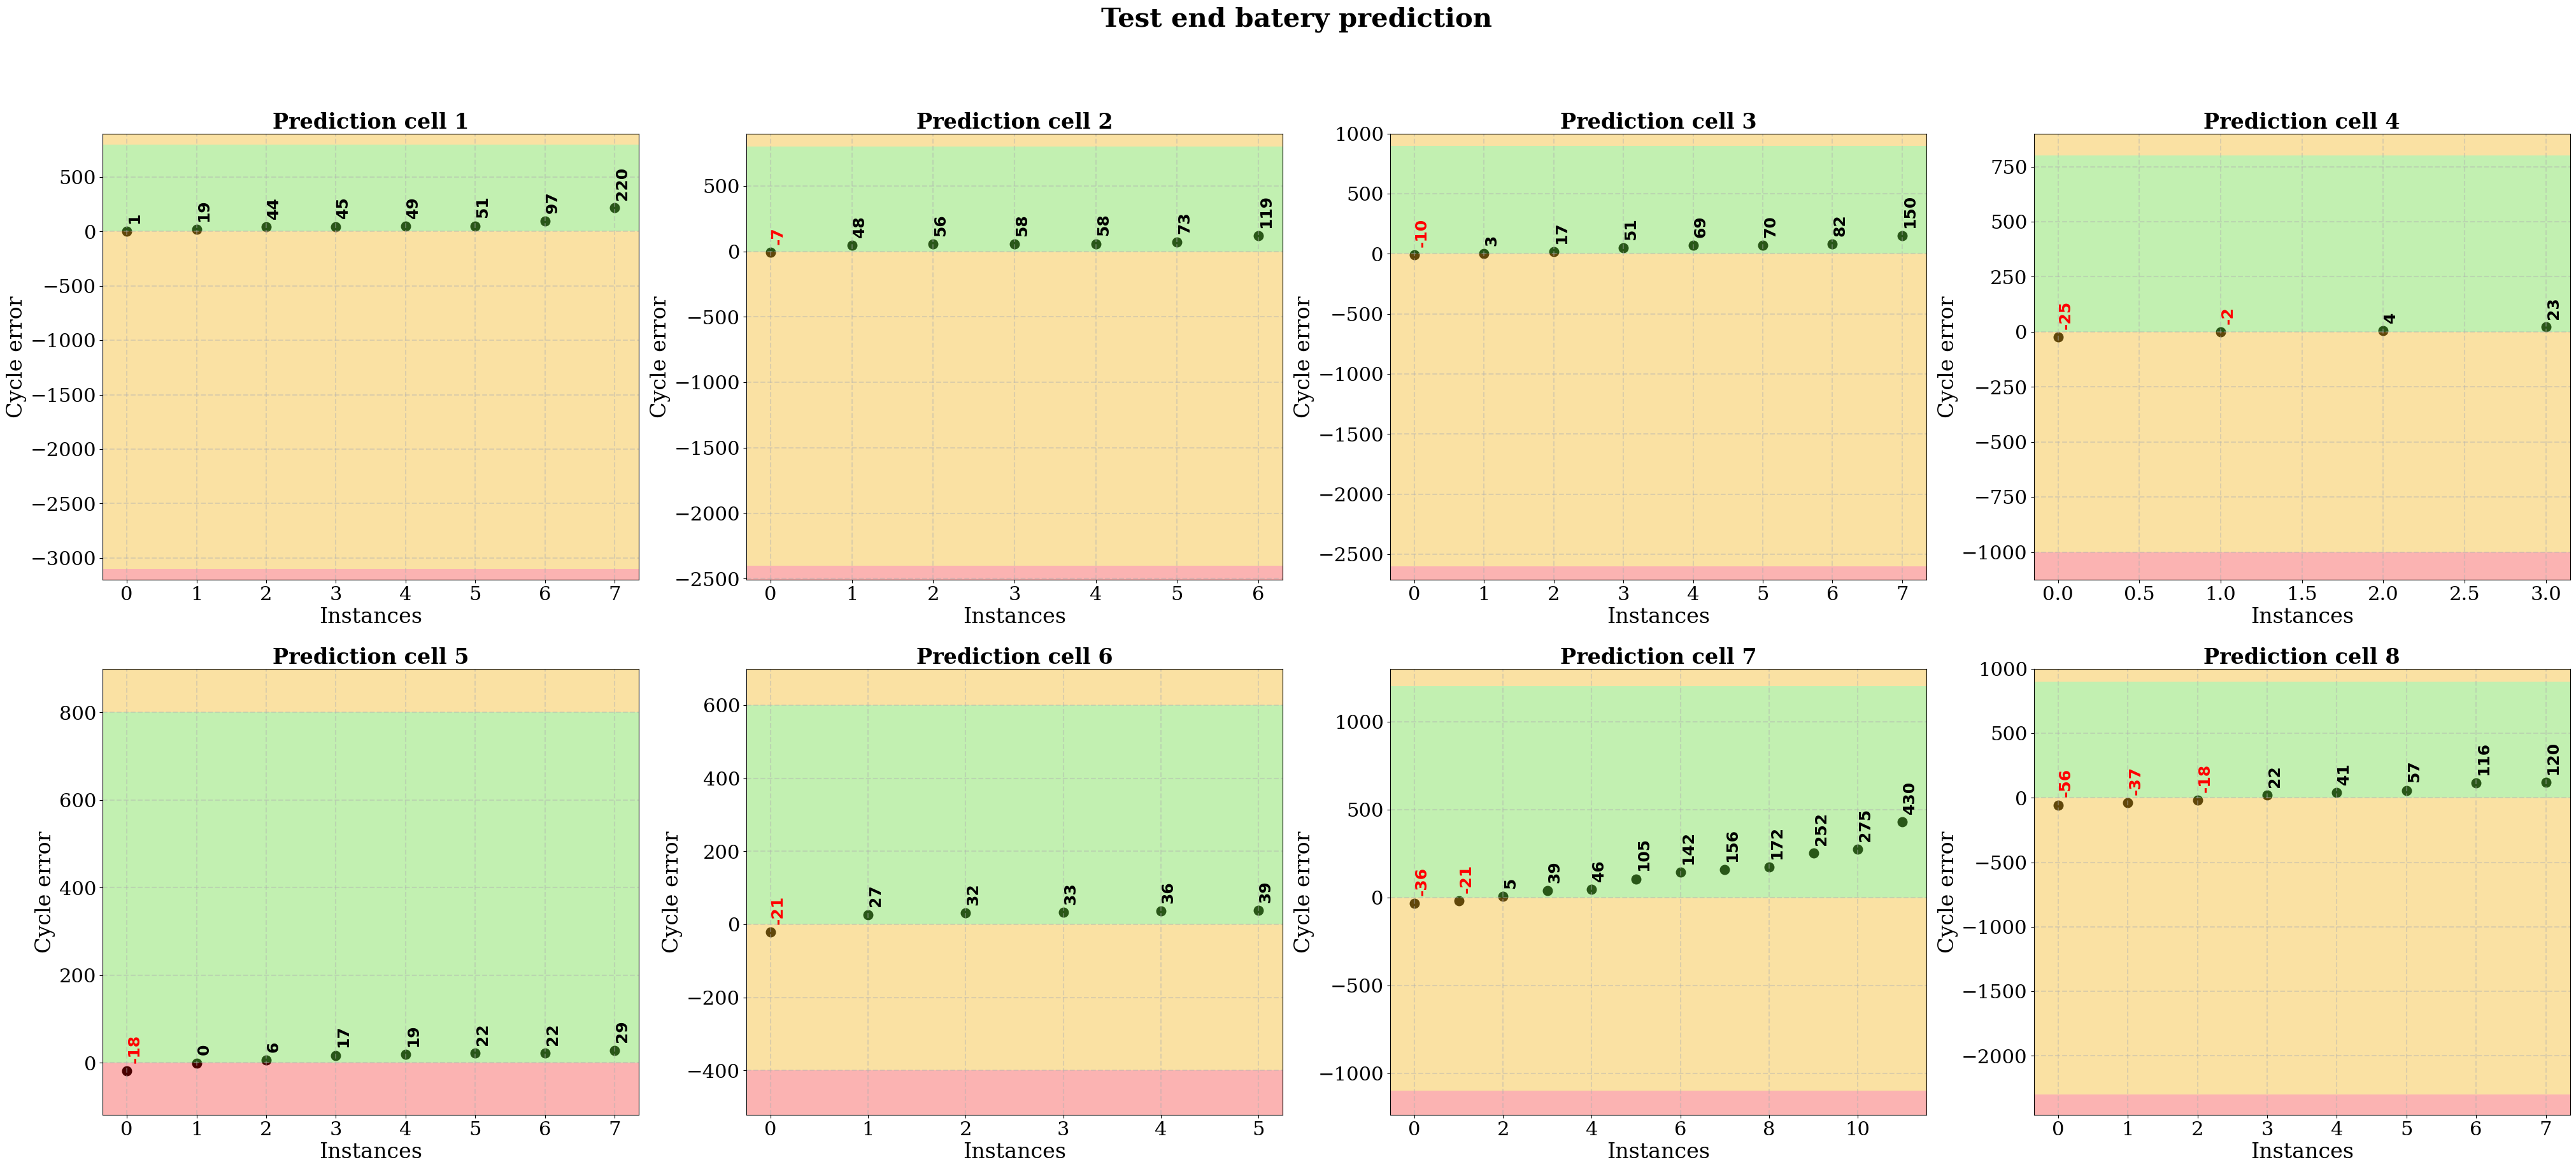

In [11]:
rf.scatter_plot_prediction(ypred, y_test, y_test_mod)
plt.suptitle('Test end batery prediction', fontsize=30, fontweight='bold', family='serif');

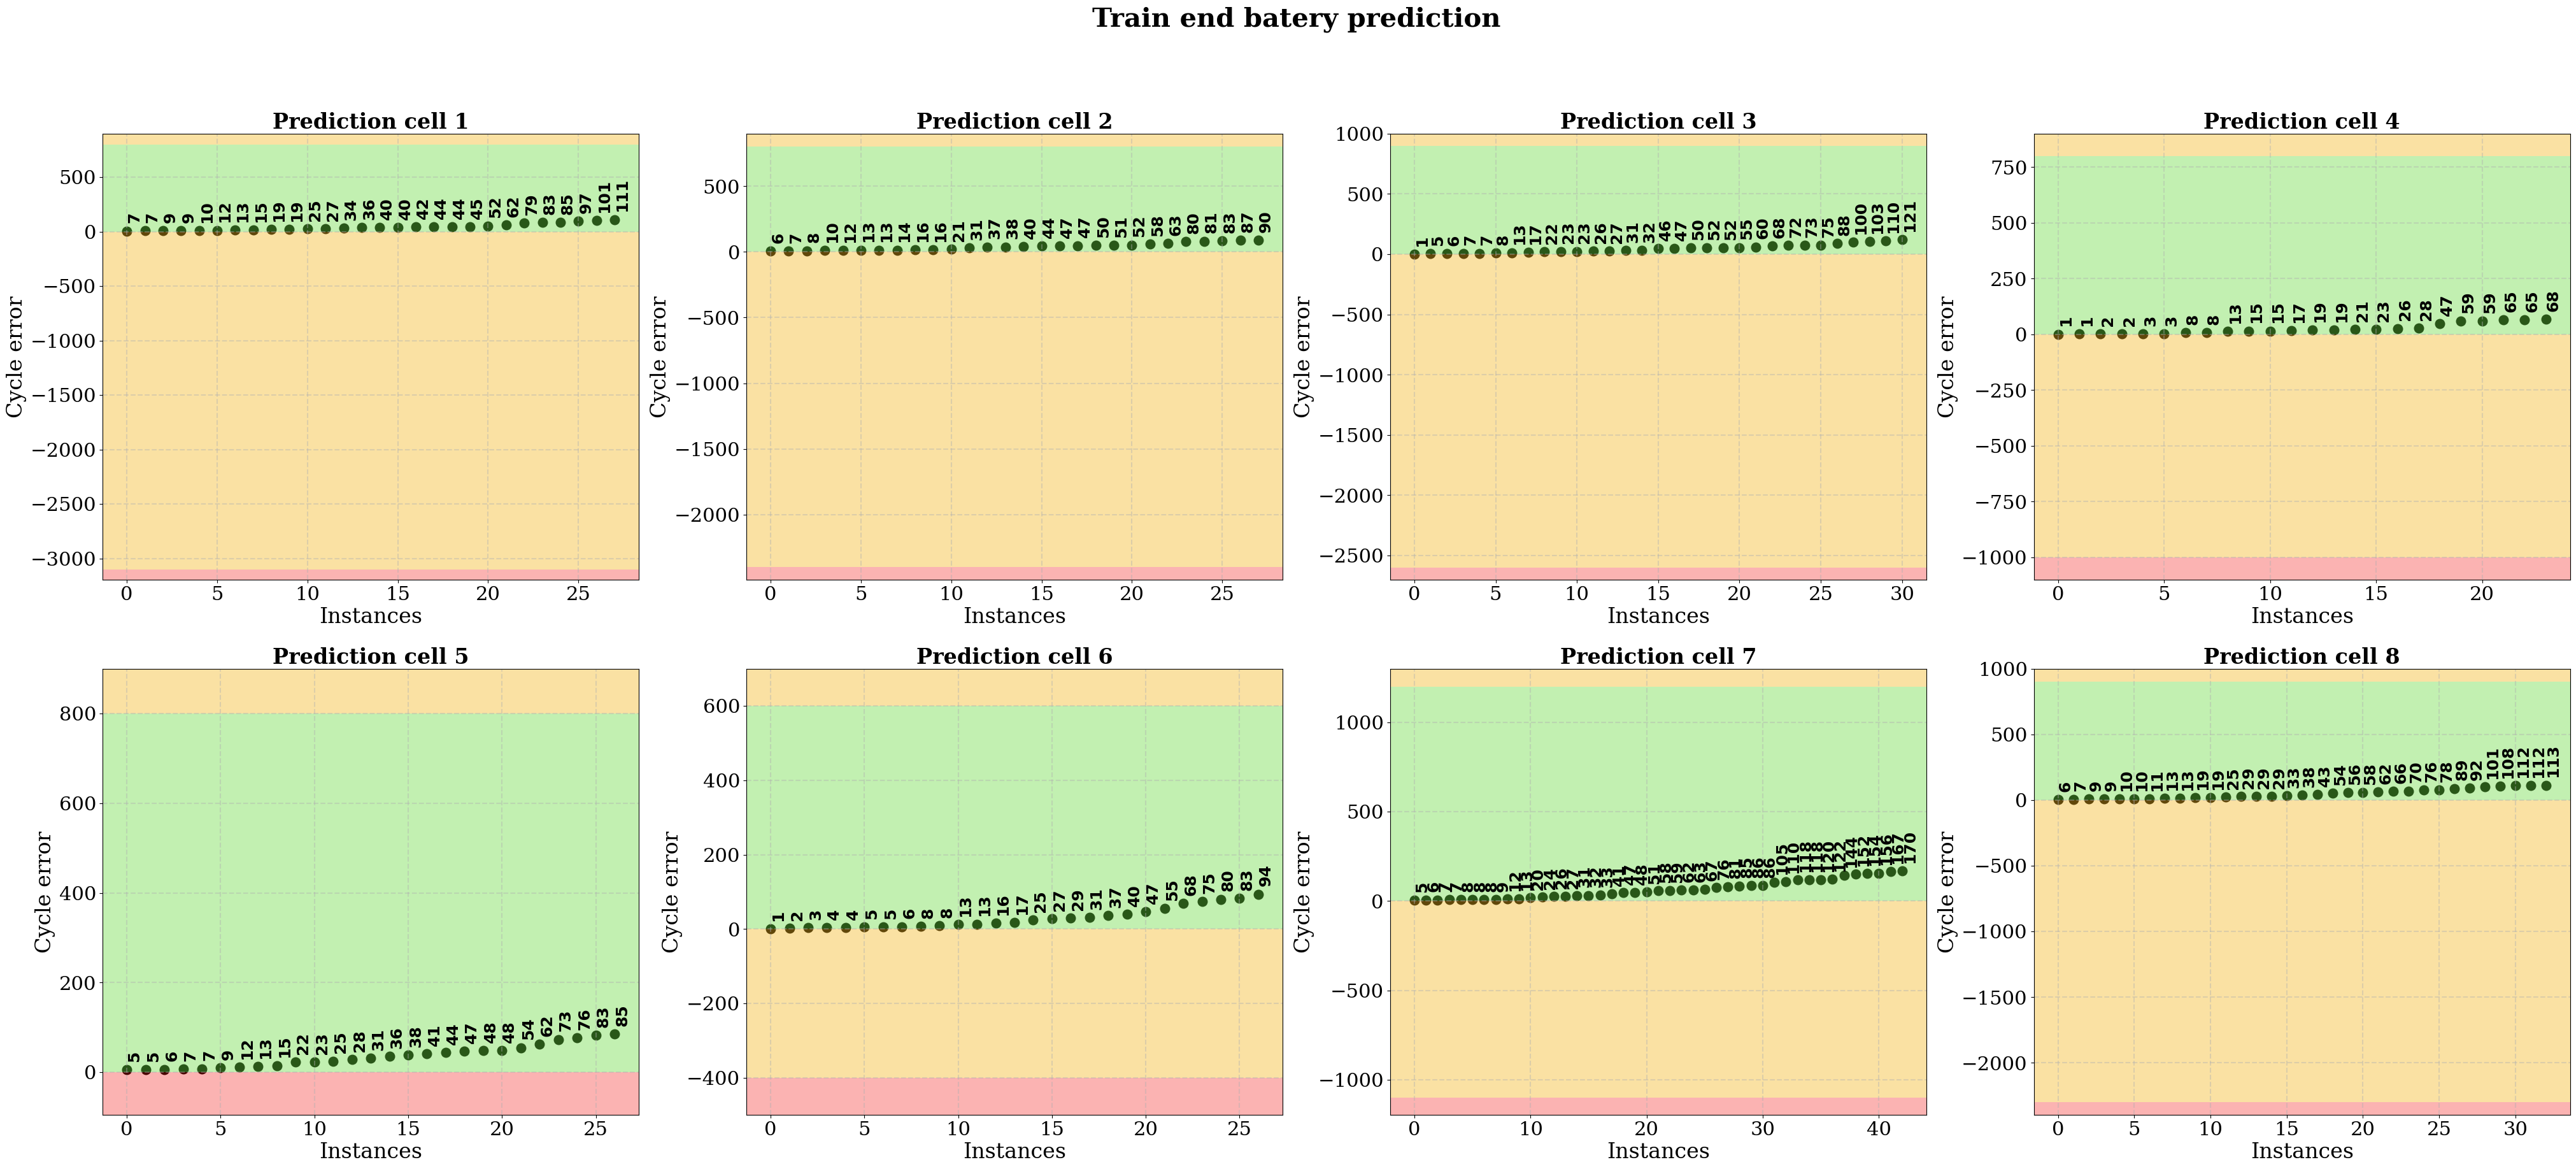

In [13]:
rf.scatter_plot_prediction(ypred_train[:241], y_train, y_train_mod)
plt.suptitle('Train end batery prediction', fontsize=30, fontweight='bold', family='serif');

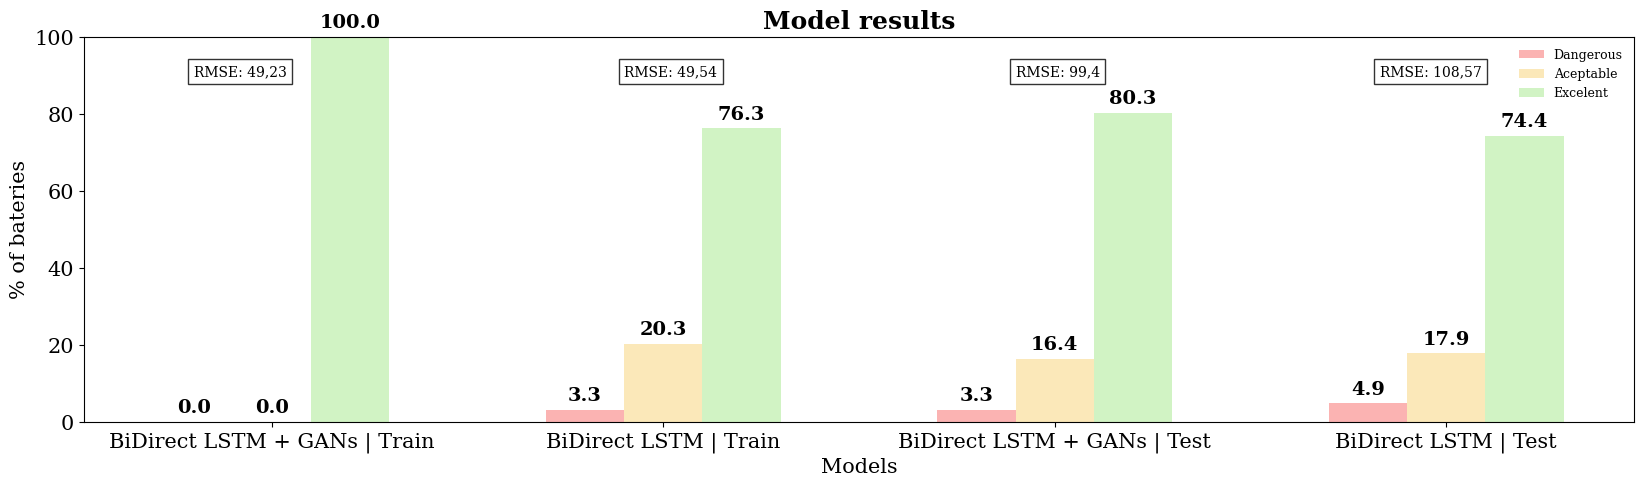

In [14]:
rf.bar_plot_comparison(['BiDirect LSTM + GANs | Train', 'BiDirect LSTM | Train', 'BiDirect LSTM + GANs | Test', 'BiDirect LSTM | Test'], \
                    [red_list_1_train, 3.3, red_list_1_test, 4.9], \
                    [yellow_list_1_train, 20.3, yellow_list_1_test, 17.9], \
                    [green_list_1_train, 76.3, green_list_1_test, 74.4])
plt.legend(loc='upper right', fontsize=9, frameon=False);
for text in plt.gca().get_legend().get_texts(): plt.setp(text, family='serif')
plt.text(-0.2, 90, 'RMSE: 49,23', fontsize=10,bbox=dict(edgecolor='black', alpha=0.8, linewidth=1, facecolor='white'), family='serif');
plt.text(0.9, 90, 'RMSE: 49,54', fontsize=10,bbox=dict(edgecolor='black', alpha=0.8, linewidth=1, facecolor='white'), family='serif');
plt.text(1.9, 90, 'RMSE: 99,4', fontsize=10,bbox=dict(edgecolor='black', alpha=0.8, linewidth=1, facecolor='white'), family='serif');
plt.text(2.83, 90, 'RMSE: 108,57', fontsize=10,bbox=dict(edgecolor='black', alpha=0.8, linewidth=1, facecolor='white'), family='serif');

----